In [1]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from convergence_helpers import *
from gaussian_mixture_grid import GaussianMixtureGrid

In [2]:
N_DIM = 10
grid10d = GaussianMixtureGrid(length=2, dimensionality=N_DIM, spacing=25, stddev=4)

In [3]:
RESULTS_DIR = "mpi_results"
num_nodes = []
times = []
samples = {}
indexes = {}
traces = {}

for filename in os.listdir(RESULTS_DIR):
    filepath = os.path.join(RESULTS_DIR, filename)
    if filename.endswith("out"):
        with open(filepath, "r") as f:
            for line in f:
                if line.startswith("Number of nodes"):
                    num_nodes.append(int(line.split()[-1]))
                if line.startswith("Elapsed Time"):
                    times.append(float(line.split()[-1]))
    elif filename.startswith("samples"):
        data = np.load(filepath)
        if len(data.shape) == 2: #fix 1 processor shape
            data = data.reshape(1, data.shape[0], data.shape[1])
        processors = data.shape[0]       
        samples[processors] = data
    elif filename.startswith("indexes"):
        data = np.load(filepath)
        if len(data.shape) == 1: #fix 1 processor shape
            data = data.reshape(1, data.shape[0])
        processors = data.shape[0]
        indexes[processors] = data
        
#merge sample traces
for p in samples.keys():
    traces[p] = joint_conv_trace([(samples[p][i], indexes[p][i]) for i in range(p)], grid10d)
    
#sort by nodes
num_nodes = np.array(num_nodes)
times = np.array(times)
order = np.argsort(num_nodes)
num_nodes = num_nodes[order]
times = times[order]

In [4]:
print num_nodes
print times

[  1   2   4   8  16  32  64 128]
[ 3005.93  1590.98   804.89   443.7    230.15   137.06    81.33    48.5 ]


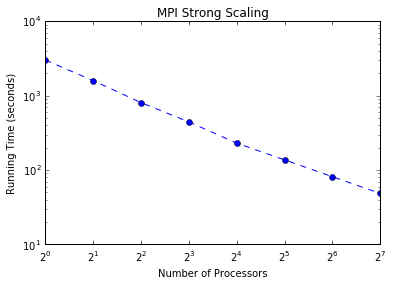

In [5]:
plt.figure(figsize=(6,4))
plt.plot(num_nodes, times, "--o")
plt.yscale("log")
plt.xscale("log", basex=2)
plt.xlabel("Number of Processors")
plt.ylabel("Running Time (seconds)")
plt.title("MPI Strong Scaling")
plt.show()

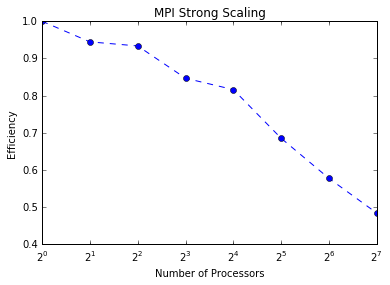

In [6]:
time_serial = times[0]
efficiency = time_serial / (times * num_nodes)

plt.figure(figsize=(6,4))
plt.plot(num_nodes, efficiency, "--o")
plt.xscale("log", basex=2)
plt.xlabel("Number of Processors")
plt.ylabel("Efficiency")
plt.title("MPI Strong Scaling")
plt.show()

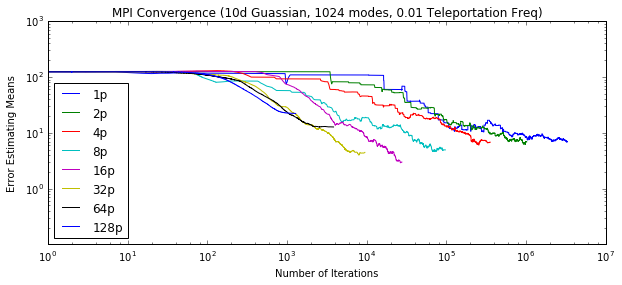

In [7]:
plt.figure(figsize=(10,4))

for p in sorted(traces.keys()):
    plt.plot(*traces[p], label='{}p'.format(p))
plt.yscale('log')
plt.xscale('log')
plt.axhline(0.1, ls='--')
plt.legend(loc='best')
plt.title("MPI Convergence (10d Guassian, 1024 modes, 0.01 Teleportation Freq)")
plt.ylabel("Error Estimating Means")
plt.xlabel("Number of Iterations")
plt.show()